# CS4035 - Cyber Data Analytics
## Lab 3 

# --- NOTES ---

- Discretize each "netflow" (which is just a single packet/row)
- For each feature, create "bins" for the values (nunique? LabelEncoder?) 
- Concatenate all of these bins into a single feature, such that the dataset only has one feature (confirm?)
- Use k-means to create clusters, and then "utilize the interaction between the features to come up with the features" (optional)


- [Student] "so each row has 1 feature after the concatenation. Since we need a 3-gram, doesn't this essentialy mean that we take row 1, row 2 and row 3 as the first 3-gram? Is then the second 3-gram, row 2, row 3, row 4?"
- [Daniel Vos] "Yes, essentially. You summarize each row with one number/symbol and take 3-grams of these numbers/symbols"

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name: Andrew Gold
### ID: 4995902

## Student 2
### Name :
### ID :

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [954]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

In [917]:
df_10 = pd.read_pickle("./dataset_10/capture20110818.pkl")
# df_10 = pd.read_pickle("./dataset_10/capture_no_background.pkl")

# Drop the following columns because...
df_10.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_10.drop(index=np.where(df_10['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_10.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_10.reset_index(drop=True, inplace=True)
df_10.head()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label
0,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,3049,978731,245317,flow=From-Normal-V51-Grill
1,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
2,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
3,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek
4,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek


## 1. Familiarization and discretization task – 1 A4

In [918]:
# First let's see what kind of null values we've got
df_10.isnull().sum()

Dur              0
Proto            0
SrcAddr          0
Sport           27
Dir              0
DstAddr          0
Dport       101196
State         1227
TotPkts          0
TotBytes         0
SrcBytes         0
Label            0
dtype: int64

In [919]:
# Fill the NaN values
df_10.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER

In [920]:
# Relabel some of the directional flows to be less ambiguous
df_10.Dir.loc[np.where(df_10.Dir == "->")] = 'send'
df_10.Dir.loc[np.where(df_10.Dir == "<-")] = 'receive'
df_10.Dir.loc[np.where(df_10.Dir == "<->")] = 'both'
df_10.Dir.loc[np.where(df_10.Dir == "<?>")] = 'other'
df_10.Dir.loc[np.where(df_10.Dir == "?>")] = 'other'
df_10.Dir.loc[np.where(df_10.Dir == "who")] = 'other'

C:\ProgramData\Anaconda3\envs\labs\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<BarContainer object of 4 artists>

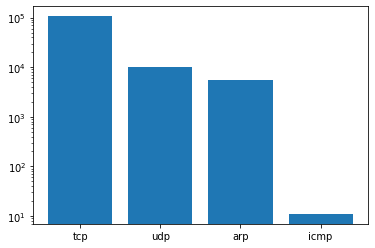

In [921]:
# Let's see what the frequency of each type of packet is
plt.yscale('log')
plt.bar(df_10.Proto.unique(), df_10.Proto.value_counts())

<BarContainer object of 4 artists>

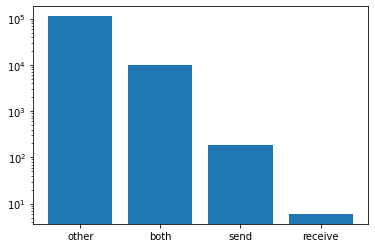

In [922]:
# frequency of each type of directional traffic
plt.yscale('log')
plt.bar(df_10.Dir.unique(), df_10.Dir.value_counts())

<BarContainer object of 28 artists>

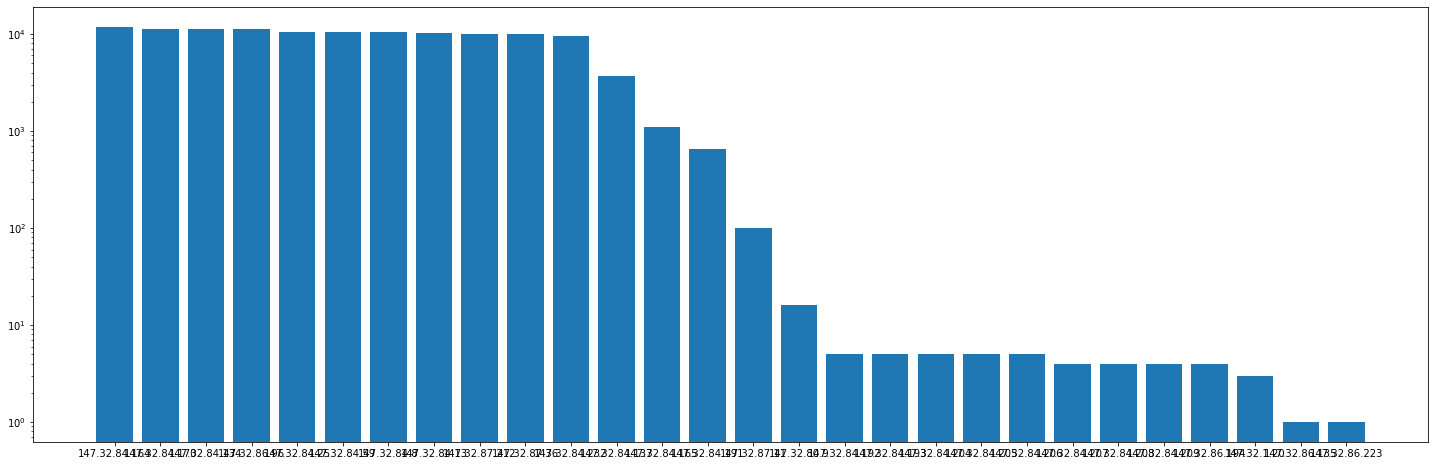

In [923]:
# visualization of amount of traffic from each source
fig = plt.figure(figsize=(25,8))
plt.yscale('log')
plt.bar(df_10.SrcAddr.unique(), df_10.SrcAddr.value_counts())

In [924]:
# Let's create a meta-label attribute for each protocol type for botnet activity vs. 'normal'
df_10['Metalabel'] = pd.Series()
df_10.Metalabel.loc[np.where(df_10.Label.str.contains('Normal'))] = 'Normal'
df_10.Metalabel.loc[np.where(df_10.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_10.Metalabel.loc[np.where(df_10.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_10.Metalabel.loc[np.where(df_10.Label.str.contains('TCP'))] = 'Botnet-TCP'

df_10


<ipython-input-924-708635db21a0>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10['Metalabel'] = pd.Series()


,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,Metalabel
0,3587.569824,tcp,147.32.84.164,54784,other,74.125.232.215,443,PA_PA,3049,978731,245317,flow=From-Normal-V51-Grill,Normal
1,198.072739,tcp,147.32.84.164,56165,other,74.125.232.197,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill,Normal
2,197.928329,tcp,147.32.84.164,57965,other,209.85.149.138,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill,Normal
3,0.000399,udp,147.32.84.170,45807,both,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek,Normal
4,0.000400,udp,147.32.84.170,35380,both,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122194,0.000743,icmp,147.32.84.164,0x0008,both,147.32.96.69,0x841e,ECO,2,196,98,flow=From-Normal-V51-Grill,Normal
122195,0.000913,icmp,147.32.84.164,0x0008,both,147.32.96.69,0x841e,ECO,2,196,98,flow=From-Normal-V51-Grill,Normal
122196,0.000414,udp,147.32.84.170,37138,both,147.32.80.9,53,CON,2,244,81,flow=From-Normal-V51-Stribrek,Normal
122197,0.000322,udp,147.32.84.170,39771,both,147.32.80.9,53,CON,2,280,81,flow=From-Normal-V51-Stribrek,Normal


In [925]:
df_10_enc = df_10.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)

# Might not want to blindly encode these
raw_labels = pd.Series(LabelEncoder().fit_transform(df_10_enc.Label.copy()))

In [926]:
print(df_10_enc.Metalabel.value_counts().to_string())

Botnet-ICMP    105977
Normal          15143
Botnet-UDP        997
Botnet-TCP         82


In [927]:
df_10_enc['EncLabel'] = pd.Series()
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('Normal'))] = 0
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3

df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')
df_10_enc.EncLabel

<ipython-input-927-56582897b981>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\labs\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0         0
1         0
2         0
3         0
4         0
         ..
122194    0
122195    0
122196    0
122197    0
122198    0
Name: EncLabel, Length: 122199, dtype: int8

In [928]:
print(df_10_enc.Metalabel.value_counts().to_string())

Botnet-ICMP    105977
Normal          15143
Botnet-UDP        997
Botnet-TCP         82


In [929]:
df_10_enc.head(10)

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,Metalabel,EncLabel
0,3587.569824,2,5,60059,1,250,427,58,308,2267,1816,flow=From-Normal-V51-Grill,Normal,0
1,198.072739,2,5,60576,1,236,944,12,13,432,252,flow=From-Normal-V51-Grill,Normal,0
2,197.928329,2,5,61335,1,165,944,12,13,432,252,flow=From-Normal-V51-Grill,Normal,0
3,0.000399,3,7,56633,0,8,593,4,1,293,13,flow=From-Normal-V51-Stribrek,Normal,0
4,0.000400,3,7,52529,0,8,593,4,1,293,13,flow=From-Normal-V51-Stribrek,Normal,0
5,0.018164,2,7,56020,3,153,944,27,5,301,176,flow=From-Normal-V51-Stribrek,Normal,0
6,3567.721924,2,7,57204,1,208,427,58,202,1869,1527,flow=From-Normal-V51-Stribrek,Normal,0
7,3511.644043,2,7,58883,1,206,427,55,105,1274,1128,flow=From-Normal-V51-Stribrek,Normal,0
8,3567.485352,2,7,54769,1,145,427,58,234,2102,1584,flow=From-Normal-V51-Stribrek,Normal,0
9,3570.136475,2,5,61544,1,207,427,55,163,1502,1361,flow=From-Normal-V51-Grill,Normal,0


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

<AxesSubplot:>

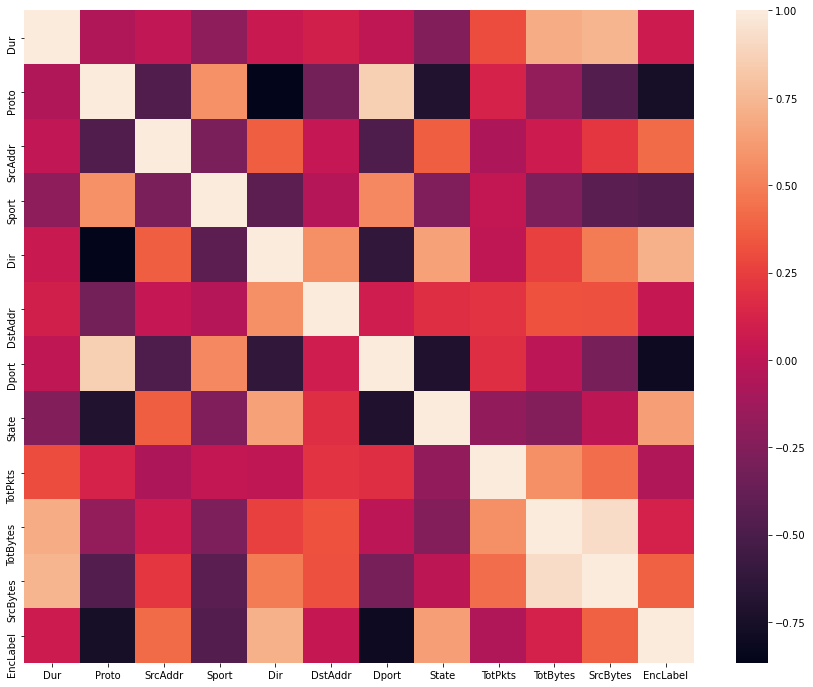

In [930]:
# Let's look at a correlation heatmap to see which are closely associated with target labels
fig = plt.figure(figsize=(15,12))
sns.heatmap(df_10_enc.corr())

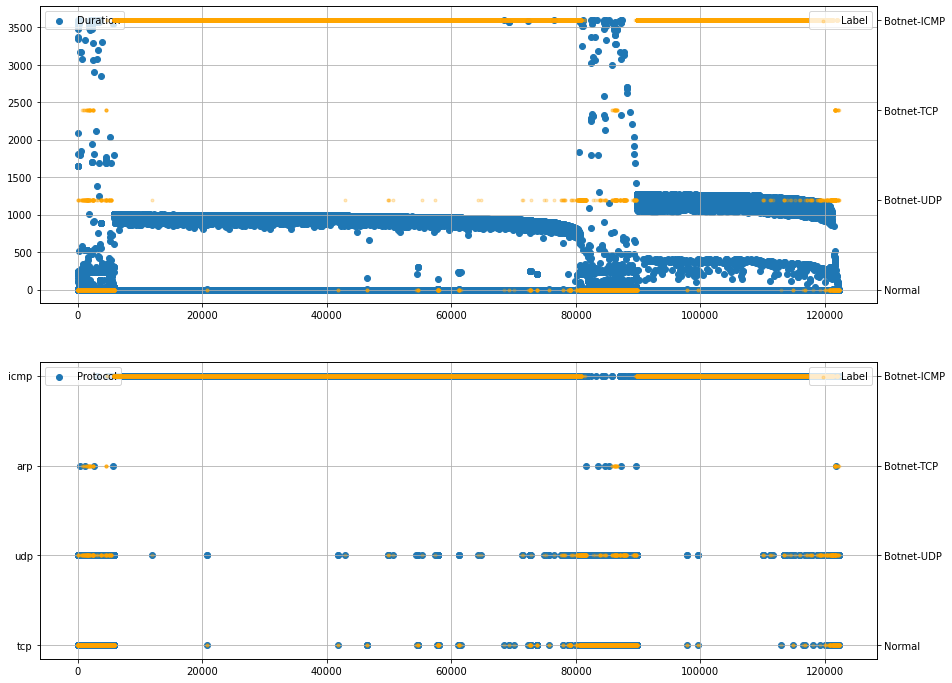

In [931]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,12))

ax1.scatter(df_10.index, df_10.Dur, marker='o', alpha=1)
ax2 = ax1.twinx()
ax1.grid()
ax2.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=0.25)
ax1.legend(['Duration'], loc='upper left')
ax2.legend(['Label'], loc='upper right')


ax3.scatter(df_10.index, df_10.Proto, marker='o', alpha=1)
ax4 = ax3.twinx()
ax3.grid()
ax4.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=0.25)
ax3.legend(['Protocol'], loc='upper left')
ax4.legend(['Label'], loc='upper right')


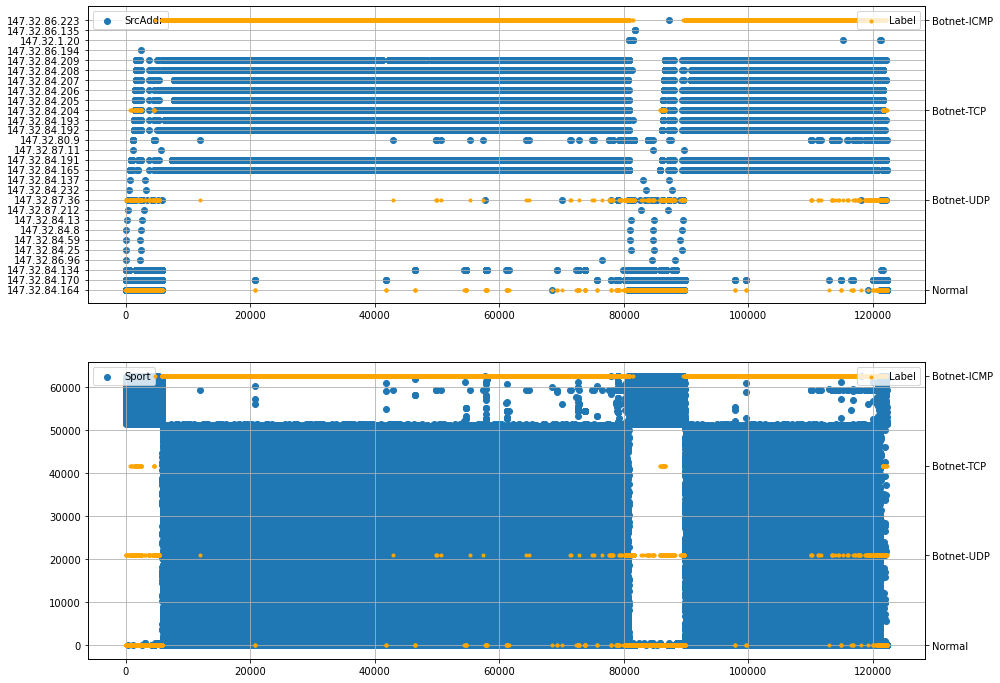

In [932]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,12))

ax1.scatter(df_10.index, df_10.SrcAddr, marker='o', alpha=1)
ax2 = ax1.twinx()
ax1.grid()
ax2.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=1)
ax1.legend(['SrcAddr'], loc='upper left')
ax2.legend(['Label'], loc='upper right')


ax3.scatter(df_10.index, df_10_enc.Sport, marker='o', alpha=1)
ax4 = ax3.twinx()
ax3.grid()
ax4.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=1)
ax3.legend(['Sport'], loc='upper left')
ax4.legend(['Label'], loc='upper right')


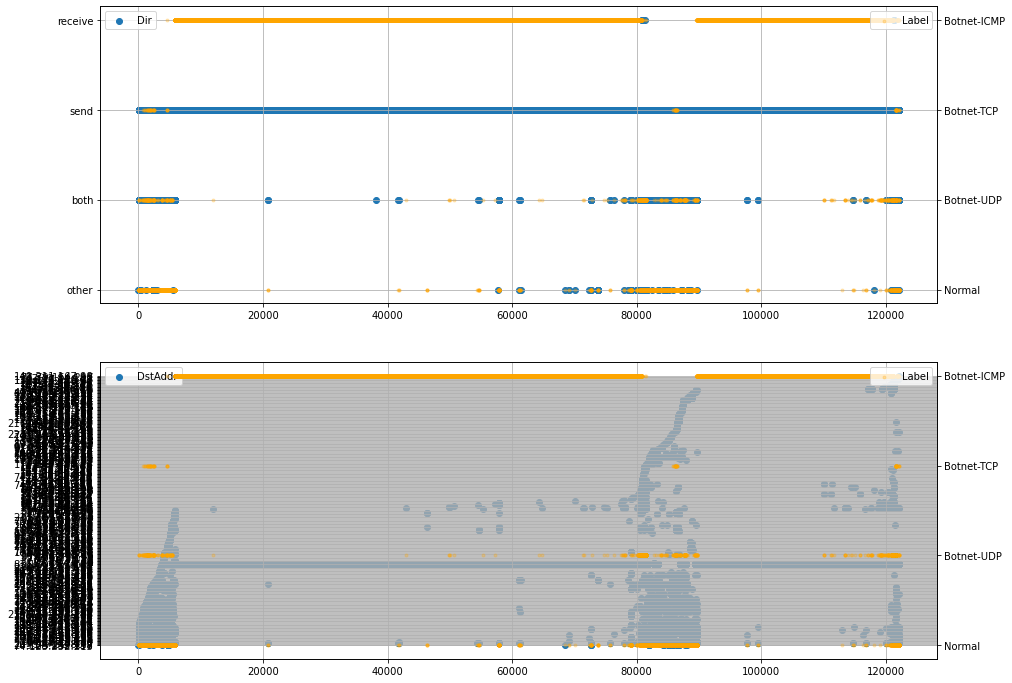

In [933]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,12))

ax1.scatter(df_10.index, df_10.Dir, marker='o', alpha=1)
ax2 = ax1.twinx()
ax1.grid()
ax2.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=0.25)
ax1.legend(['Dir'], loc='upper left')
ax2.legend(['Label'], loc='upper right')


ax3.scatter(df_10.index, df_10.DstAddr, marker='o', alpha=1)
ax4 = ax3.twinx()
ax3.grid()
ax4.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=0.25)
ax3.legend(['DstAddr'], loc='upper left')
ax4.legend(['Label'], loc='upper right')


**Above we can see that a very specific destination address is associated with Botnet-ICMP attacks.**

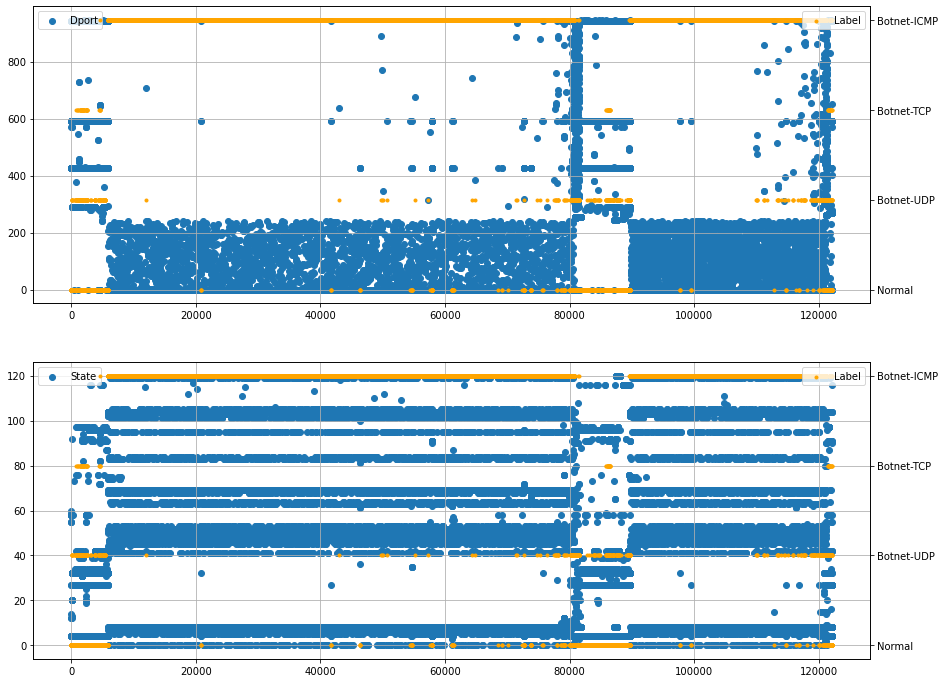

In [934]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,12))

ax1.scatter(df_10.index, df_10_enc.Dport, marker='o', alpha=1)
ax2 = ax1.twinx()
ax1.grid()
ax2.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=1)
ax1.legend(['Dport'], loc='upper left')
ax2.legend(['Label'], loc='upper right')


ax3.scatter(df_10.index, df_10_enc.State, marker='o', alpha=1)
ax4 = ax3.twinx()
ax3.grid()
ax4.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=1)
ax3.legend(['State'], loc='upper left')
ax4.legend(['Label'], loc='upper right')


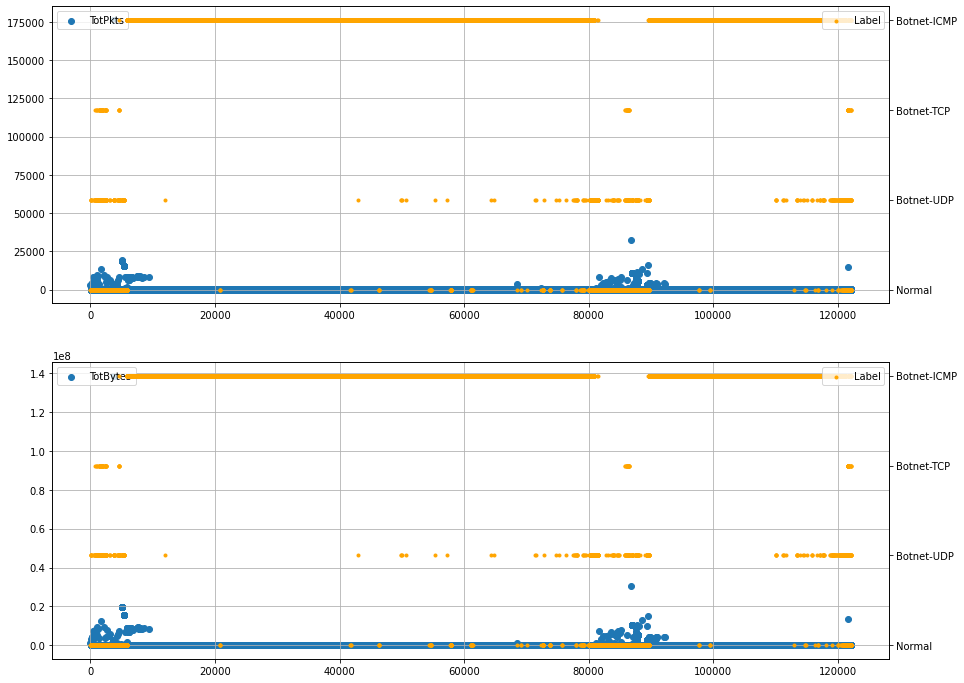

In [935]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,12))

ax1.scatter(df_10.index, df_10.TotPkts, marker='o', alpha=1)
ax2 = ax1.twinx()
ax1.grid()
ax2.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=1)
ax1.legend(['TotPkts'], loc='upper left')
ax2.legend(['Label'], loc='upper right')


ax3.scatter(df_10.index, df_10.TotBytes, marker='o', alpha=1)
ax4 = ax3.twinx()
ax3.grid()
ax4.scatter(df_10.index, df_10.Metalabel, marker=".", color='orange', alpha=1)
ax3.legend(['TotBytes'], loc='upper left')
ax4.legend(['Label'], loc='upper right')


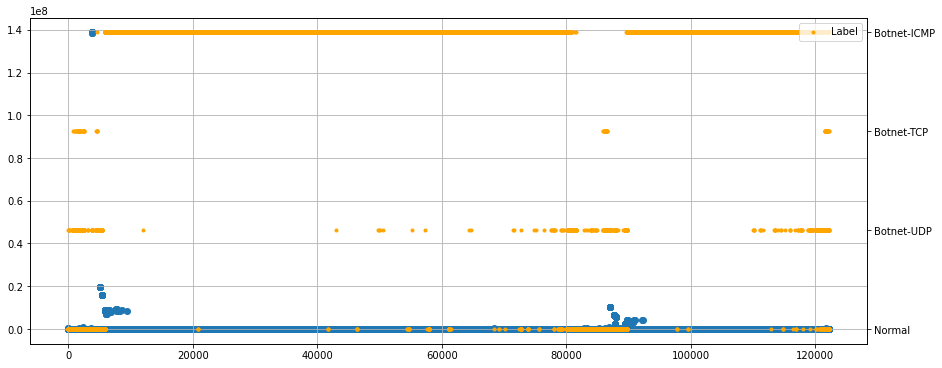

In [936]:
fig = plt.figure(figsize=(15,6))

plt.scatter(df_10.index, df_10.SrcBytes, marker='o', alpha=1)
plt.grid()
ax2 = plt.twinx()
ax2.scatter(df_10.index, df_10.Metalabel, color='orange', marker=".", alpha=1)
plt.legend(['SrcBytes'], loc='upper left')
ax2.legend(['Label'], loc='upper right')


---
We can see from the above plots that `State`, `Protocol`, and `DstAddr` all are closely linked with types of attacks. However, `DstAddr` is of course going to be a attacker-chosen target, so filtering just for a specific address seems useless in this context. Therefore, we'll combine `State` and `Protocol`.

First, let's bin each of the attributes and then concatenate them.

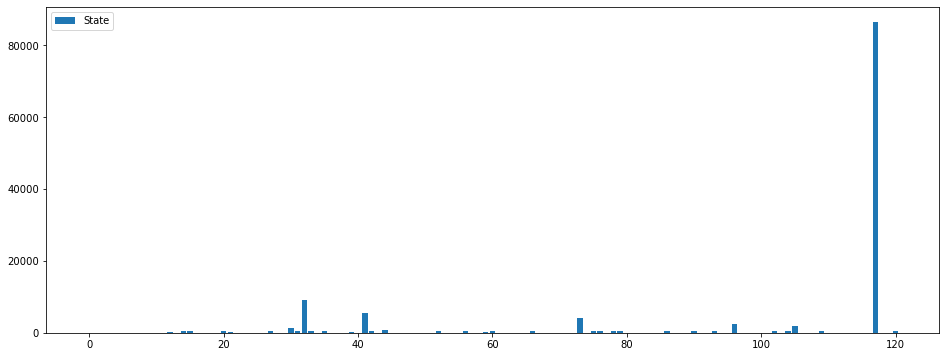

In [937]:
# Let's see the distribution of each encoded state:
fig = plt.figure(figsize=(16,6))
# plt.yscale('log')
sorted_counts = np.sort(df_10_enc.State.value_counts().index)
plt.bar(df_10_enc.State.value_counts().index, df_10_enc.State.value_counts().sort_index())
plt.legend(['State'])

In [942]:
# State category 104 has more entries than all the others combined. 
# Therefore, let's create a binary variable and bin them into just 2 categories:
df_10_enc['EncState'] = df_10_enc.State.copy().astype('int8')
df_10_enc.EncState.loc[np.where(df_10_enc.State != 104)] = 0
df_10_enc.EncState.loc[np.where(df_10_enc.State == 104)] = 1

df_10_enc.EncState.value_counts()

C:\ProgramData\Anaconda3\envs\labs\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\envs\labs\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1    86348
0    35851
Name: EncState, dtype: int64

<BarContainer object of 4 artists>

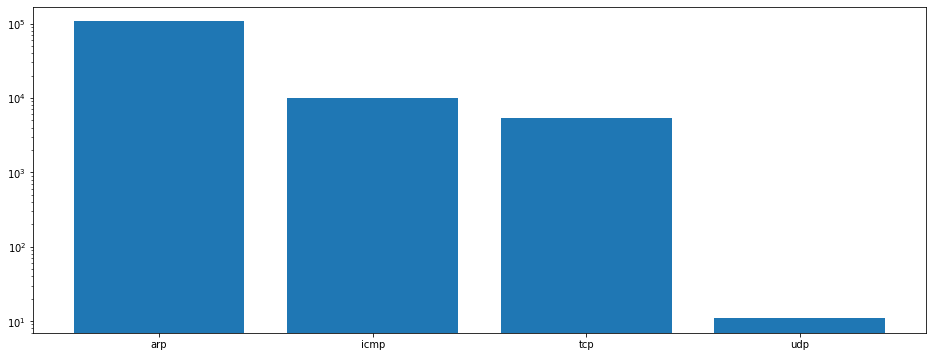

In [943]:
# Let's see the distribution of each encoded protocol:
fig = plt.figure(figsize=(16,6))
plt.yscale('log')
plt.bar(np.sort(df_10.Proto.unique()), df_10.Proto.value_counts())

In [951]:
# We can see that State and Protocol are the two most outstanding features with the Metalabel w.r.t. botnet behavior
# Let's combine these with the encoded labels

df_10_enc['ProtoState'] = df_10_enc.Proto.astype('str') + df_10_enc.EncState.astype('str') + df_10_enc.EncLabel.astype('str')
df_10_enc.ProtoState = df_10_enc.ProtoState.astype('int32')
df_10_x = pd.concat([df_10_enc.ProtoState, df_10_enc.EncLabel], axis=1)

df_10_x.value_counts()

ProtoState  EncLabel
111         1           86348
101         1           19629
300         0            9076
200         0            5343
302         2             997
100         0             713
203         3              82
0           0              11
dtype: int64

In [964]:
sha = hashlib.sha256()
sha.update(b"256")
sha.digest()

b'Q\xe8\xea(\x0bD\xe1i4\xd4\xd6\x11\x90\x1f=:\xfcAx\x98@\xac\xdf\xf8\x19B\xc2\xf6P\t\xcdR'

### 1b. Discretize selected features

### 1b. Answers and explanation

## 2. Frequent task – 1/2 A4 (Individual)

### 2a. Use the SPACE SAVING algorithm

### 2b. Analysis and answers to the questions

## 3. Sketching task – 1/2 A4 (Individual)

### 3a. COUNT-MIN sketch


### 3b. Analysis and answers to the questions

## 4. Min-wise locality sensitive hashing task – 1/2 A4 (Individual)

### 4a. Implementation

### 4b. Analysis and answers to the questions

## 5. Random hyperplane locality sensitive hashing task – 1/2 A4 (Individual)

### 5a. Implementation - locality sensitive hashing

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Botnet profiling task – 1/2 A4

### 6a. Learn a sequential model

### 6b. Analysis and answers to the questions.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


### 7b. Analysis and answers to the questions.

## 8. Bonus Task 1/2 A4

### 8a. Provide implementation and analysis.